# 黑神话：悟空 销量预测 Black Myth: Wukong Sales Forecasting
本次预测将使用steam游戏平台各大游戏的关注数与销量数据构建一元线性回归模型，以用于预测黑神话悟空在2024年发布后的销量。
This prediction will use the attention count and sales data of major games on the steam gaming platform to construct a one-dimensional linear regression model for use in predicting the sales of Black Myth: Wukong upon its release in 2024.

## 1. 数据预览与模型拟合  Data preview and model building

加载模块  Import library

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

加载数据集  Import dataset

In [5]:
data_for_ana = pd.read_csv("./data.csv", usecols=[1, 2])
print("dataset shape is {}".format(data_for_ana.shape))

dataset shape is (25, 2)


查看数据样式  View Data Shape

In [6]:
data_for_ana.head()

,followers,sales
0,0.24145,0.28
1,1.11810,0.94
2,0.56754,1.95
3,1.84461,2.23
4,1.25246,2.62


In [7]:
data_for_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   followers  25 non-null     float64
 1   sales      25 non-null     float64
dtypes: float64(2)
memory usage: 528.0 bytes


画出散点图和回归直线  Draw a scatter plot and regression line

(0.0, 21.820813526832545)

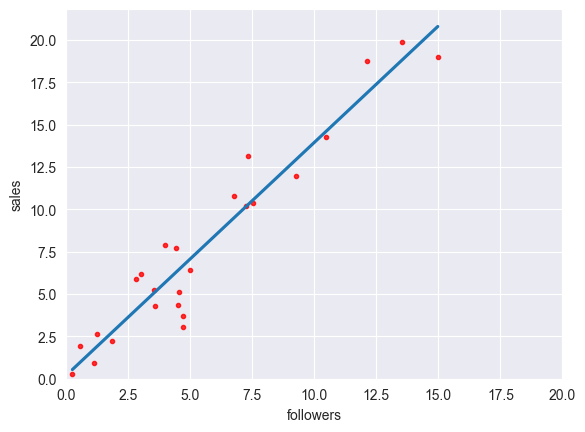

In [8]:
sns.regplot(x="followers", y="sales", data=data_for_ana, ci=None, scatter_kws={"color": "r", "s": 9})
plt.xlim(0, 20)
plt.ylim(ymin=0)

绘制热力图  Heat mapping

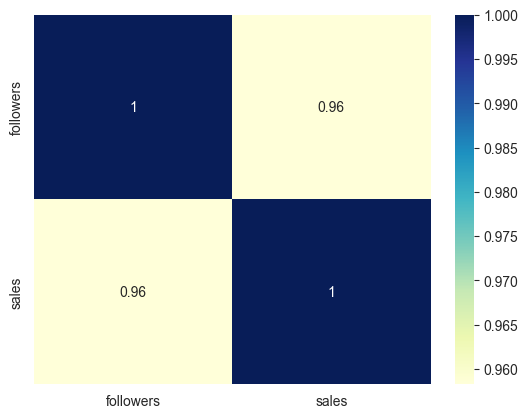

In [9]:
corr = data_for_ana.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [10]:
# r的显著性检验
def r_test_statistic(r, n):
    if r == 1:
        return 0
    else:
        a = abs(r)
        b = np.sqrt((n - 2) / (1 - r ** 2))
        c = a * b
        return c


# 计算相关系数检验的统计量
corr_test_stat = corr.map(lambda x: r_test_statistic(x, len(data_for_ana)))
print(corr_test_stat)

           followers      sales
followers   0.000000  16.077147
sales      16.077147   0.000000


根据显著性水平0.05和自由度n-2， 计算t分布临界值

In [11]:
alpha = 0.05
t_score = scipy.stats.t.isf(alpha / 2, df=len(data_for_ana) - 2)
print(t_score)

2.068657610419041


从散点图不难看出，followers和sales可能存在线性关系
由于16.077147 > 2.068657610419041，表明followers和sales之间存在显著的正线性相关关系

加载拟合模块  Load regression Module

In [12]:
from sklearn import linear_model

开始进行拟合  Starting the regression

In [13]:
#实例化线性回归模型对象
model = linear_model.LinearRegression()
# 使用数据集对模型进行训练
model.fit(data_for_ana[['followers']], data_for_ana[['sales']])
# 求出线性回归方程的自变量和截距，model_coef 是回归系数，model_intercept 是截距
model_coef = model.coef_
model_intercept = model.intercept_
print(model_coef)
print(model_intercept)
print("一元线性回归曲线为y={:.3f}x+{:.3f}".format(model_coef[0][0], model_intercept[0]))

[[1.37473963]]
[0.20917319]
一元线性回归曲线为y=1.375x+0.209


## 2. 评价模型——拟合优度  Evaluating the model - goodness of fit

导入模块  Import library

In [14]:
import statsmodels.api as sm

开始评价  Start to evaluate

In [15]:
X = data_for_ana[['followers']]
Y = data_for_ana[['sales']]
X1 = sm.add_constant(data_for_ana[['followers']])
est = sm.OLS(Y, X1).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     258.5
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           5.30e-14
Time:                        17:18:57   Log-Likelihood:                -47.184
No. Observations:                  25   AIC:                             98.37
Df Residuals:                      23   BIC:                             100.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2092      0.580      0.360      0.722      -0.991       1.410
followers      1.3747      0.086     16.077      0.000       1.198       1.552
==============================================================================
Omnibus:                        0.538   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.590
Skew:                          -0.299   Prob(JB):                        0.745
Kurtosis:                       2.542   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. 用估计方程预测  Forecasting with estimating equations

### 3.1 置信区间  confidence interval

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# 去除因为未来语法改变而导致的警告
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

n = 25  # 样本数
data_for_ana['y_hat'] = model.predict(data_for_ana[['followers']])  # 预测值
MSE = mean_squared_error(Y, model.predict(X))
s_e = sqrt(MSE)
x_bar = data_for_ana[['followers']].mean()
total = sum((data_for_ana['followers'] - float(x_bar)) ** 2)
data_for_ana['cntmp'] = (data_for_ana['followers'] - float(x_bar)) ** 2 / total
data_for_ana['lcon'] = data_for_ana['y_hat'] - np.array(
    t_score * s_e * np.sqrt(1 / n + data_for_ana['cntmp']))  # 由之前的公式得到
data_for_ana['Ucon'] = data_for_ana['y_hat'] + np.array(t_score * s_e * np.sqrt(1 / n + data_for_ana['cntmp']))

### 3.2 预测区间  Forecast range

In [17]:
data_for_ana['lpre'] = data_for_ana['y_hat'] - np.array(t_score * s_e * np.sqrt(1 + 1 / n + data_for_ana['cntmp']))
data_for_ana['Upre'] = data_for_ana['y_hat'] + np.array(t_score * s_e * np.sqrt(1 + 1 / n + data_for_ana['cntmp']))

### 3.3 画图  Plot

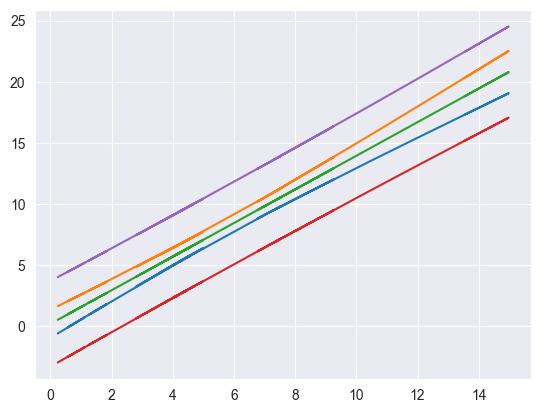

In [18]:
plt.plot(data_for_ana[['followers']], data_for_ana[['lcon']])
plt.plot(data_for_ana[['followers']], data_for_ana[['Ucon']])
plt.plot(data_for_ana[['followers']], data_for_ana[['y_hat']])
plt.plot(data_for_ana[['followers']], data_for_ana[['lpre']])
plt.plot(data_for_ana[['followers']], data_for_ana[['Upre']])
plt.show()

## 4. 回归模型诊断——残差分析、方差齐性检验和正态性检验  Regression model diagnostics - residual analysis, chi-square test and normality test

### 4.1 残差图  Residual plot

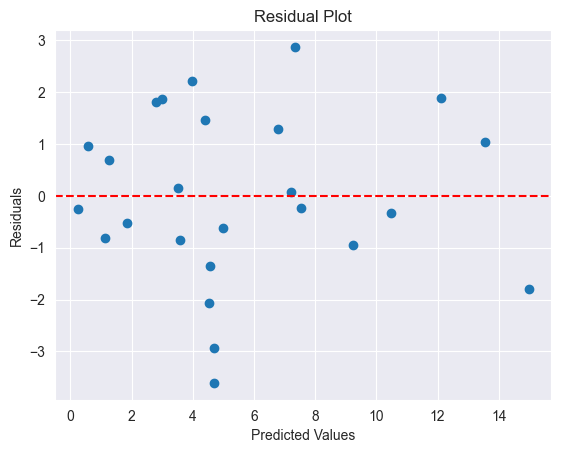

In [19]:
e = Y - model.predict(X)
plt.scatter(X, e)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### 4.2 标准化残差图  Standardised residual plot

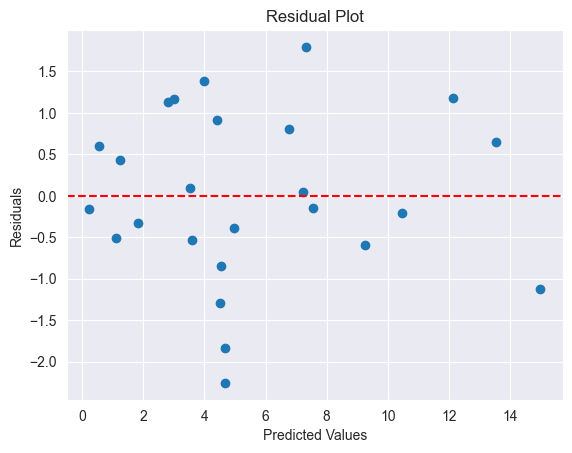

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE = mean_squared_error(Y, model.predict(X))
std_e = (Y - model.predict(X)) / sqrt(MSE)
plt.scatter(X, std_e)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')  # 轴标签我嫌懒就没改了
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### 4.3 分位图  Q-Q Plot

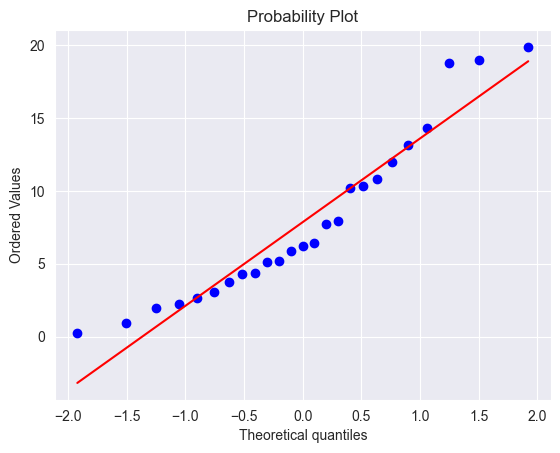

In [21]:
from scipy import stats

stats.probplot(data_for_ana['sales'], dist='norm', plot=plt)
plt.show()

从分位图不难看出，正态性检验是满足的。